In [ ]:
#Download east weights from here https://www.dropbox.com/scl/fi/buzhchmq1p65y6lkxlci5/frozen_east_text_detection.pb?rlkey=g3ms0cx0s7cq02uiptgrp19xz&st=zhs6zncg&dl=0

In [1]:
import os, sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression
from PIL import Image

txt_images = list()

def east_detect(image):
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (640, 640)
    
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    start = time.time()
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
    		# compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    scaled_boxes = []
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        scaled_boxes.append((startX,startY,endX,endY))
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        txt_images.append(Image.fromarray(orig[startY:endY, startX:endX]))

    
    print(time.time() - start)
    return orig, scaled_boxes

In [2]:
image = cv2.imread("test_img.jpg")

out_image, scaled_boxes = east_detect(image)

cv2.imwrite("sample_output.jpg", out_image)

0.3779866695404053


True

In [3]:
cropped_regions = [Image.fromarray(image[box[1]:box[3],box[0]:box[2]]) for box in scaled_boxes]
cropped_regions[0]

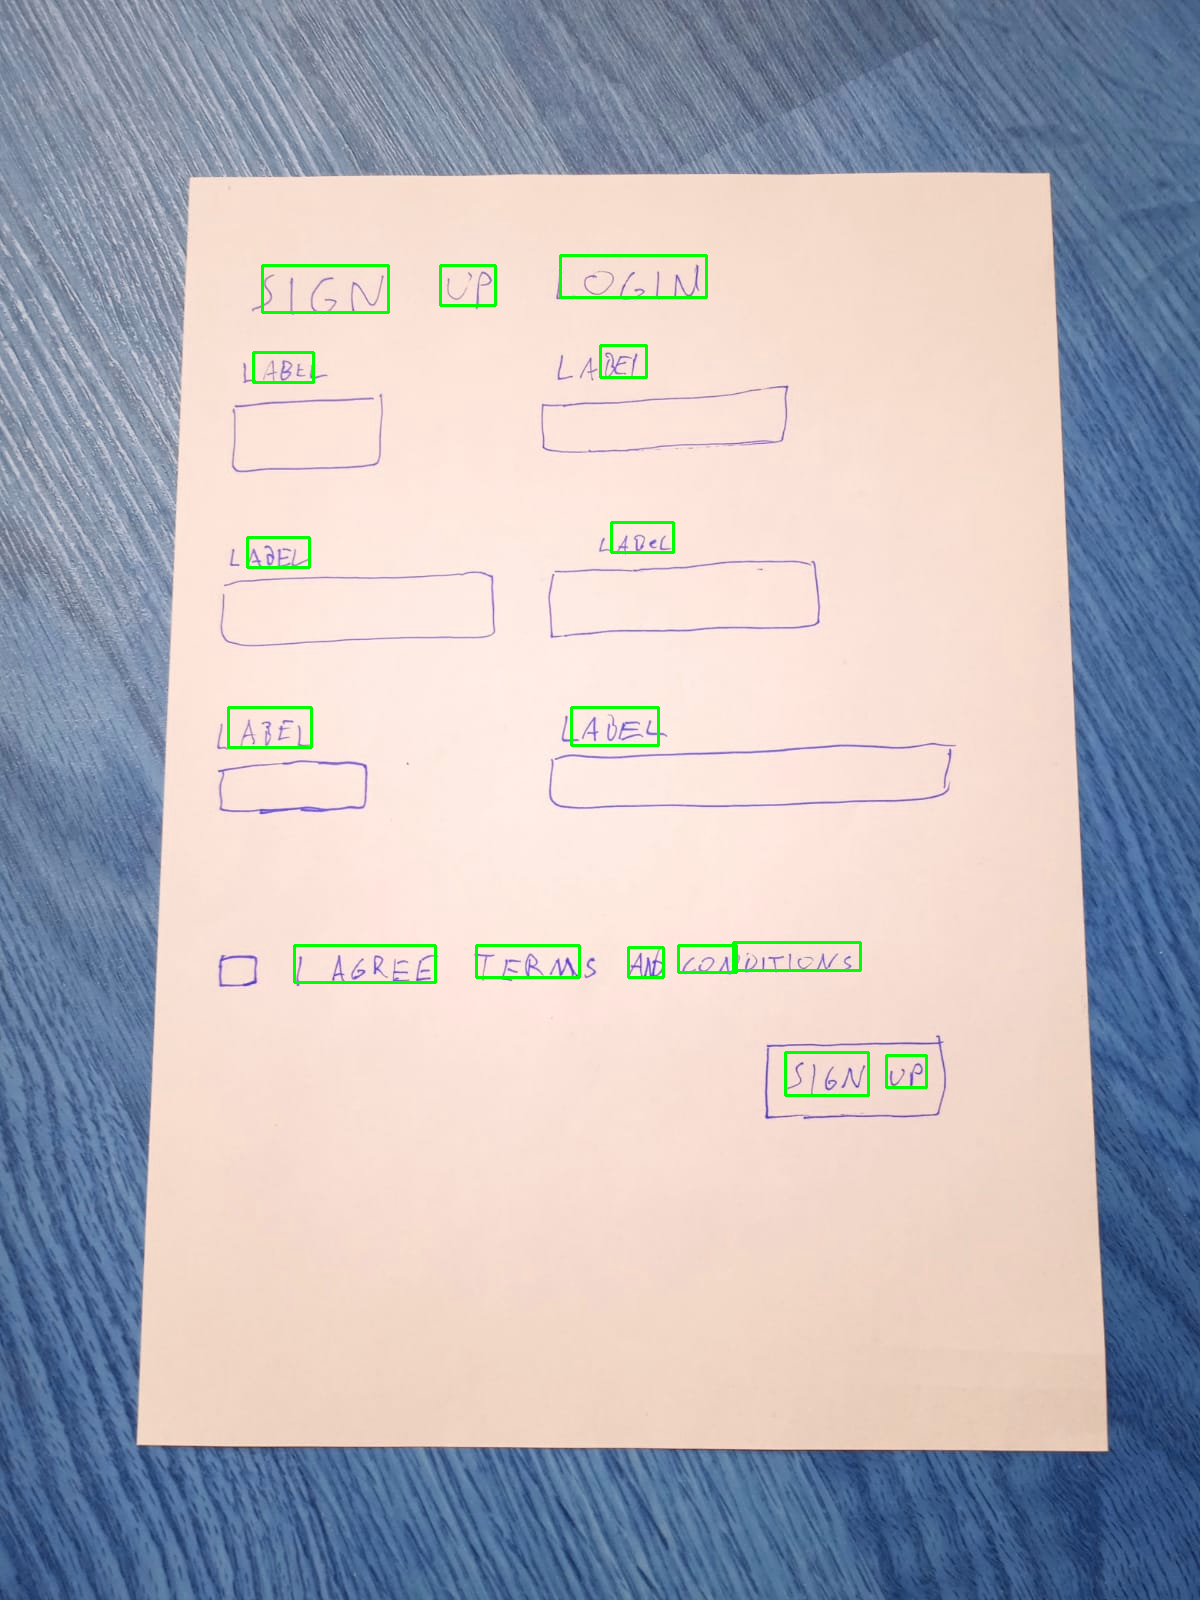

In [4]:
Image.fromarray(out_image)